# Standard Probabilities

Though there are many modes of playing Magic: The Gathering, Standard follows a few set rules. There is a minimum of 60 cards per deck, and at the start of each game, each player draws 7 cards. All cards are either lands, or require lands to play. Thus there is a required balance for each deck regarding the amount of lands necessary to cast. Too many, and there will be nothing to cast. You are left weak, and there is little game to be played. Too few lands, and you only get to gaze upon all of your options without being able to partake in any of them.

Thus, this calculator hopes to solve this issue. 'Solve' is a misnomer, though. This calculator hopes to simulate probability distributions of land amounts in your opening hand given the distribution of card types in your deck.

In [5]:
import numpy as np
import random as random
import pandas as pd
import altair as alt
import vl_convert as vlc

alt.data_transformers.disable_max_rows()
alt.renderers.enable("png")


class Deck:

    # Initializes deck
    # Assumes all card counts are 0
    # Requires random, numpy library
    
    def __init__ (self, lands=0, creatures=0, sorceries=0, instants=0, enchantments=0, artifacts=0, others=0):
        self.lands = lands
        self.creatures = creatures
        self.sorceries = sorceries
        self.instants = instants
        self.enchantments = enchantments
        self.artifacts = artifacts
        self.others = others        # I don't know what could go here, but better safe than sorry

        # Creates draw pile - maybe change to set down the line?
        self.library = []
        # Creates separate list for cards that have been drawn
        self.drawn = []

        # Creates a dict and iterates through to generate the library
        cardtypes = {'land':lands, 'creature':creatures, 'sorcery':sorceries, 'instant':instants, 'enchantment':enchantments, 'artifact':artifacts, 'other':others}

        for key in cardtypes:
            for i in np.arange(0, cardtypes[key]): # Gets length of each type, creates a list length n, where n is Deck.count()
                self.library.append(key)

    # Counts number of cards in deck, returns a warning if less than Standard 60 requirement
    def count(self):
        count = self.lands + self.creatures + self.sorceries + self.instants + self.enchantments + self.artifacts + self.others
        if count < 60:
            print('There are less than 60 cards in this deck.')
            return count
        return count
    
    # Shuffles library
    def shuffle(self):
        random.shuffle(self.library)

    # Adds n items to self.drawn, deletes items from self.library
    def draw(self, n=1):
        for i in np.arange(0, n):
            self.drawn.append(self.library[i])
        del self.library[:n]

    # Resets the library and reshuffles. Useful for simulations.
    def reset(self):
        self.library.extend(self.drawn)
        del self.drawn[:]
        self.shuffle()
    
    # Adds drawn to library, shuffles, draws 1 less card than 7 for each mulligan
    # Set n to number of mulligans taken
    def mulligan(self, n=1):
        self.reset()        
        draw_count = 7 - n
        self.draw(draw_count)
    
    # Returns counts of drawn pile to be read in simulations
    # Mulligan automatically logs whether the data is stored for a diminished draw - number attached is n in self.mulligan(n) 
    def record(self):
        dict = {'land':0, 'creature':0, 'sorcery':0, 'instant':0, 'enchantment':0, 'artifact':0, 'other':0, 'mulligan':0}
        n = len(self.drawn)
        dict['mulligan'] = 7 - n
        for i in self.drawn:
            dict[i] = dict[i]+1
        return dict


Below, a deck 'y' is initialized. It is horribly built, but that will be represented. The deck is then shuffled, 7 cards are drawn and printed, then a mulligan is taken and the drawn cards are printed again.

In [6]:
y = Deck(lands = 5, enchantments = 10, creatures = 25, instants = 10)

y.shuffle()
y.draw(7)
print(y.drawn)
y.mulligan()
print(y.drawn)

['creature', 'instant', 'creature', 'instant', 'creature', 'instant', 'creature']
['enchantment', 'instant', 'creature', 'land', 'creature', 'instant']


Further, this information can be recorded to a dictionary to be read later into a dataframe.

In [7]:
y.record()

{'land': 1,
 'creature': 2,
 'sorcery': 0,
 'instant': 2,
 'enchantment': 1,
 'artifact': 0,
 'other': 0,
 'mulligan': 1}

# Simulation

For simulations, we are most interested in the number of lands in each deck. For general purpose, lets initialize a deck with 22 lands. This is a recommended number I recall reading in an official deckbuilder guide for the new Foundations set recently. The class comes with an attribute "others", which will account for all cards in our deck that are *not* lands.

In [8]:
land22 = Deck(lands=22, others=38)
sims = []

for i in np.arange(0, 5000):
    land22.reset()
    land22.draw(7)
    sims.append(land22.record())

print('Sample Sims:')
print(sims[:2])

Sample Sims:
[{'land': 5, 'creature': 0, 'sorcery': 0, 'instant': 0, 'enchantment': 0, 'artifact': 0, 'other': 2, 'mulligan': 0}, {'land': 4, 'creature': 0, 'sorcery': 0, 'instant': 0, 'enchantment': 0, 'artifact': 0, 'other': 3, 'mulligan': 0}]


As the data is stored, it is exceptionally easy to turn into a dataframe, and in turn be plotted.

In [9]:
sims_df = pd.DataFrame(sims)
sims_df.head(5)

,land,creature,sorcery,instant,enchantment,artifact,other,mulligan
0,5,0,0,0,0,0,2,0
1,4,0,0,0,0,0,3,0
2,1,0,0,0,0,0,6,0
3,3,0,0,0,0,0,4,0
4,1,0,0,0,0,0,6,0


Finally, a visualization tool of choice can be used to process this data! Personally, despite the heartache it causes, I am called to Altair.

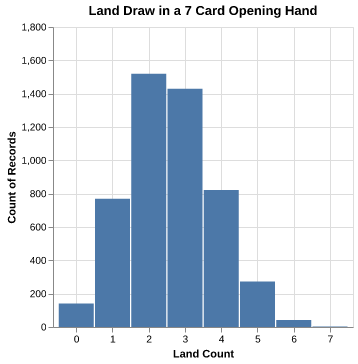

In [10]:
alt.Chart(sims_df, title = 'Land Draw in a 7 Card Opening Hand').mark_bar(size = 35).encode(
    alt.X("land:Q").scale(domain=(-0.5, 7.5)).title('Land Count'),
    alt.Y('count()').scale(domain=(0, 1800)),
)

But that draw set is boring! Lets play with the red-green deck I just built. Looking at the cards now, I desperately want to rebuild it. I counted artifact creatures under creatures, as well.

In [11]:
rg_deck = Deck(lands=24,creatures=20,instants=6,sorceries=5,enchantments=4,artifacts=1)

rg_sims = []

for i in np.arange(0, 5000):
    rg_deck.reset()
    rg_deck.draw(7)
    rg_sims.append(rg_deck.record())

rg_df = pd.DataFrame(rg_sims)
rg_df.head(5)

,land,creature,sorcery,instant,enchantment,artifact,other,mulligan
0,2,1,1,3,0,0,0,0
1,3,1,0,2,1,0,0,0
2,2,2,1,1,0,1,0,0
3,2,1,0,3,1,0,0,0
4,1,4,1,1,0,0,0,0


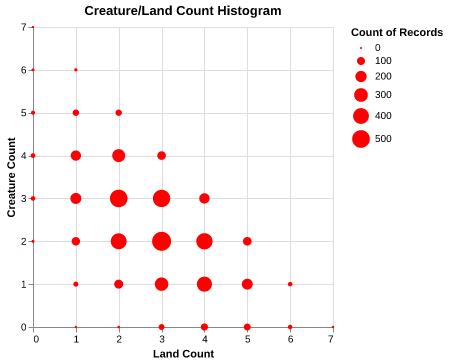

In [12]:
alt.Chart(rg_df, title='Creature/Land Count Histogram').mark_circle(color='red').encode(
    alt.X('land:Q').title('Land Count'),
    alt.Y('creature:Q').title('Creature Count'),
    size='count()',
)

What about comparing mulligans?

In [13]:
rg_mulligan1 = []
for i in np.arange(0, 5000):
    rg_deck.reset()
    rg_deck.mulligan(1)
    rg_mulligan1.append(rg_deck.record())

rg_mulligan1_df = pd.DataFrame(rg_mulligan1)

rg_mulligan2 = []
for i in np.arange(0, 5000):
    rg_deck.reset()
    rg_deck.mulligan(2)
    rg_mulligan2.append(rg_deck.record())

rg_mulligan2_df = pd.DataFrame(rg_mulligan2)

We've got all of this data for taking a mulligan once and then another time. What can we do with this? Well, we can examine how the distributions compare between the number of cards drawn.

In [14]:
rg_sims.extend(rg_mulligan1)
rg_sims.extend(rg_mulligan2)

all_df = pd.DataFrame(rg_sims)

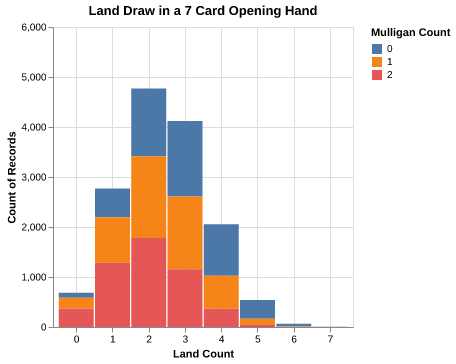

In [16]:
alt.Chart(all_df, title = 'Land Draw in a 7 Card Opening Hand').mark_bar(size = 35).encode(
    alt.X("land:Q").scale(domain=(-0.5, 7.5)).title('Land Count'),
    alt.Y('count()').scale(domain=(0, 6000)),
    alt.Color('mulligan:N').title('Mulligan Count')
)